### Gosling ancients (Sub analysis)

Beyond the primary interest of differentiating between the ancients and controls and get contamination estimates for the controls, another question of interest is, how different are the various sources of populations in the Gosling data. The ancients in Gosling data comprise of five groups - "Chokhopani", "Kyang", "Rhirhi", "Mebrak" and "Samdzong".

Of the 48 ancients sequenced, one chokhopani sample had only 1 read mapped to it and hence was removed from the study.
In this script, the questions we answer 

- How do the different ancient populations in Gossling data vary?
- Can we relate those differences to age, or mapdamage results or endogenous DNA content?

In [ ]:
library(aRchaic)
library(CountClust)

In [1]:
## Read the Gossling signature counts data and assign label to each sample (ancient or control)

gossling_data <- get(load("../processed_data/annagosling2016-counts-table.rda"))
system.time(gossling_data_clubbed <- club_signature_counts(gossling_data))
gossling_data_clubbed <- gossling_data_clubbed[-28,];


names <- rownames(gossling_data_clubbed);
control_indices <- c(grep("EXN", names), grep("Libneg", names), grep("PCRneg", names))

labs <- character();
labs <- rep("ancient", dim(gossling_data_clubbed)[1])
labs[control_indices] <- "controls"

indices <- which(labs == "ancient")

gossling_ancients <- gossling_data_clubbed[indices, ]

   user  system elapsed 
 19.143   0.474  20.160 

In [2]:
## Load the metadata on the samples, covering contamination estimate, mapdamage height, endogenous DNA etc.

metadata <- get(load("../data/Gosling_metadata/metadata_ordered.rda"))

In [3]:
## Define the signature factor levels for the Gosling samples 

signature_set <- colnames(gossling_ancients)
sig_split <- t(sapply(1:length(signature_set), function(x) return(strsplit(signature_set[x], "")[[1]][1:8])))
new_sig_split <- matrix(0, dim(sig_split)[1], 5);
new_sig_split[,1] <- sig_split[,1]
new_sig_split[,2] <- sig_split[,2]
new_sig_split[,3] <- sapply(1:length(signature_set), function(x) return(paste(sig_split[x,3:6], collapse="")))
new_sig_split[,4] <- sig_split[,7]
new_sig_split[,5] <- sig_split[,8]

levels(new_sig_split[,1]) <- c("0", "1", "2", "3", "4")

pos <- t(sapply(1:length(signature_set), function(x)
{
  y = strsplit(signature_set[x], "")[[1]]
  return(paste(y[10:length(y)], collapse=""))
}))



mat <- matrix(0, dim(new_sig_split)[1], dim(new_sig_split)[2])
for(k in 1:dim(new_sig_split)[2]){
  temp <- as.factor(new_sig_split[,k])
  mat[,k] <- as.numeric(as.matrix(plyr::mapvalues(temp, from = levels(temp), to = 0:(length(levels(temp))-1))))
}

pos <- as.numeric(pos)
pos <- pos - min(pos)
pos <- factor(pos, levels = 0:22)

signatures <- mat;
signature_pos <- cbind.data.frame(signatures, pos)

In [7]:
#topic_clus <- topics(gossling_ancients, K=2, tol=10, type="independent", signatures = signature_pos)
#save(topic_clus, file="../processed_data/maptpx-runs/topic-clus-pooled-ancients-gosling-2-independent.rda")

## Read in the GOM output

topic_clus <- get(load("../processed_data/maptpx-runs/topic-clus-pooled-ancients-gosling-2-independent.rda"))

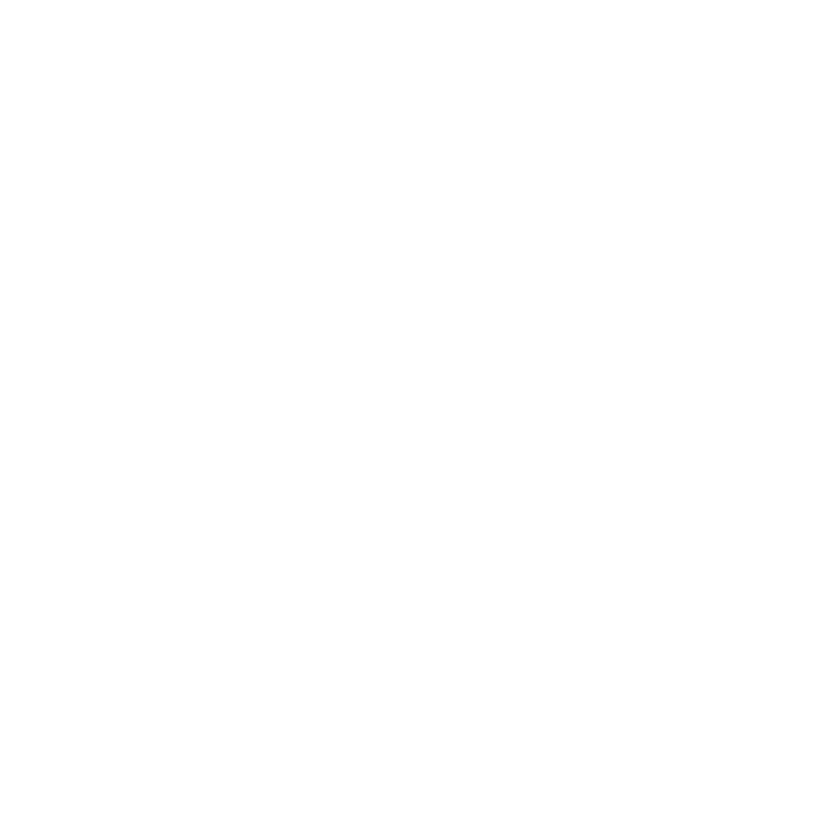

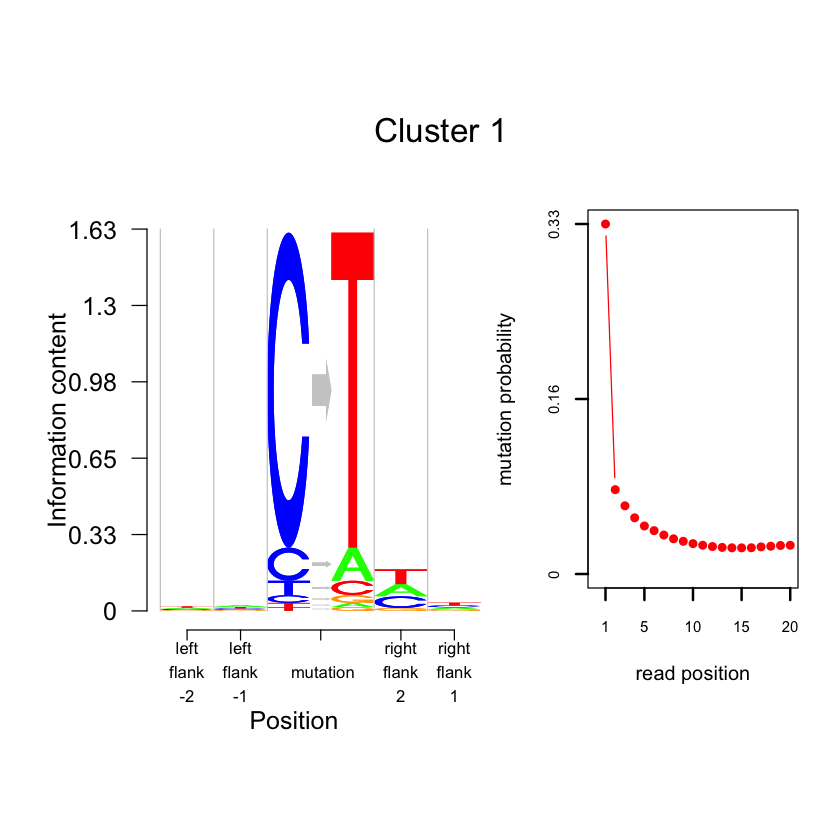

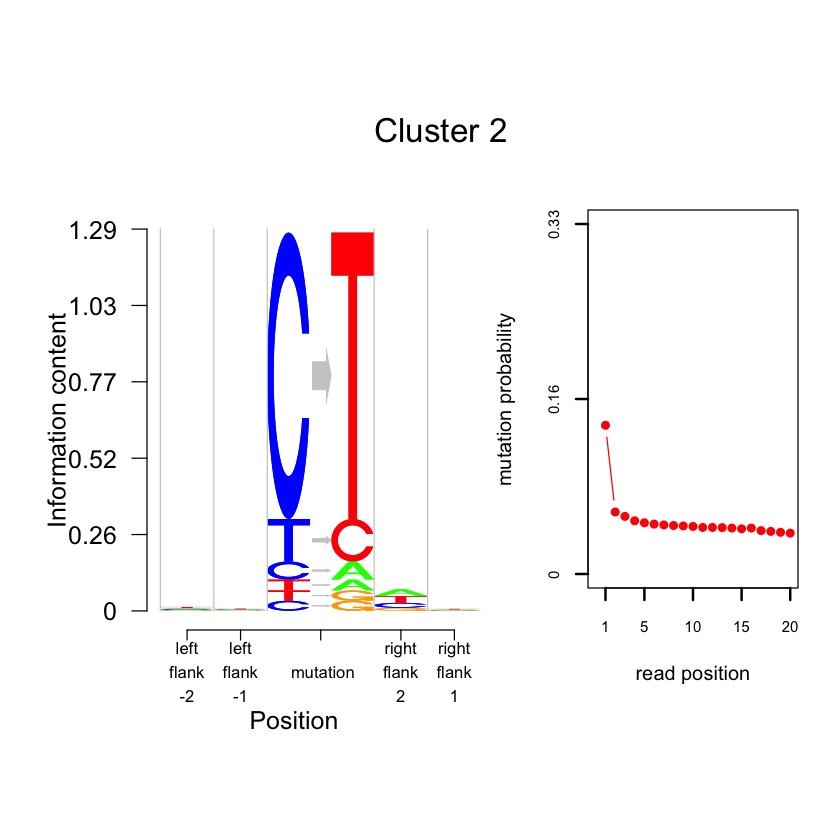

In [6]:
plot.new()
damageLogo_pos(topic_clus$theta)

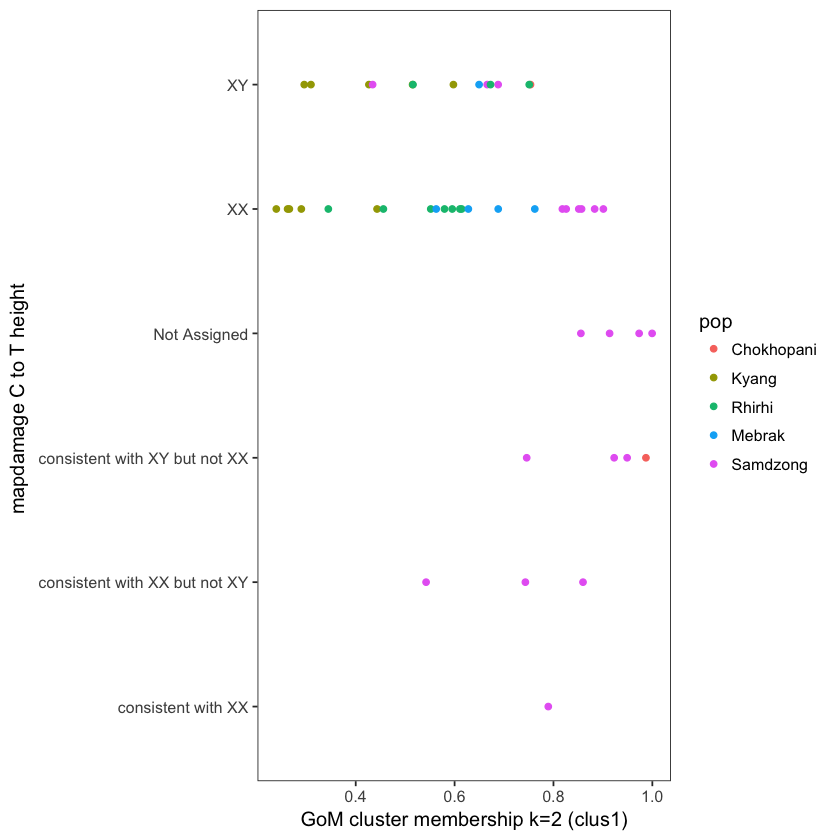

In [14]:
## Match the membership propotions from topic model fit to Sex information

omega <- topic_clus$omega

pop_names <- metadata$Sample[indices]
pop_names_1 <- as.factor(substring(pop_names, 1, 1))

levels(pop_names_1) = c("Chokhopani", "Kyang", "Rhirhi", "Mebrak", "Samdzong")

dat <- data.frame("omega" = omega[,1], "sex"= metadata$Sex.determination[indices], "pop"= pop_names_1)
ggplot2::qplot(omega, sex, col=pop, data=dat, xlab="GoM cluster membership k=2 (clus1)",
               ylab="sex determination")

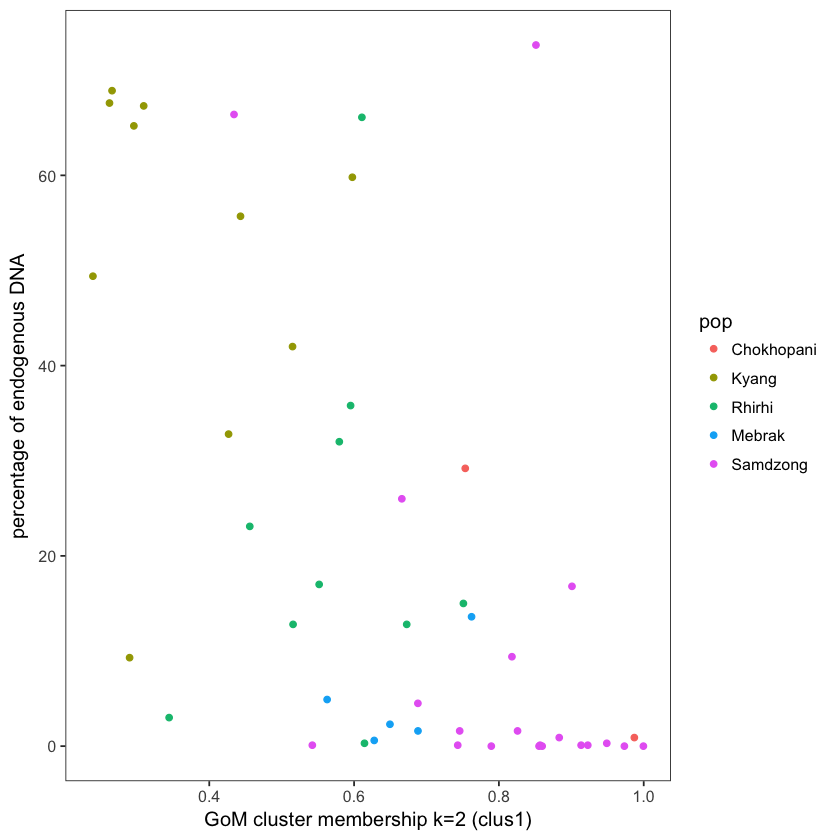

In [11]:
## Plot of the membership proportions to the percentage of endogenous DNA.

tmp <- as.character(metadata$endogenous.[indices])    
endogenous <- as.numeric(as.character(sapply(tmp, function(x) return(substr(x, 1, nchar(x)-1)))))

dat <- data.frame("omega" = omega[,1], "endogenous"= endogenous, "pop"= pop_names_1)
ggplot2::qplot(omega, endogenous, col=pop, data=dat, xlab="GoM cluster membership k=2 (clus1)",
               ylab="percentage of endogenous DNA")

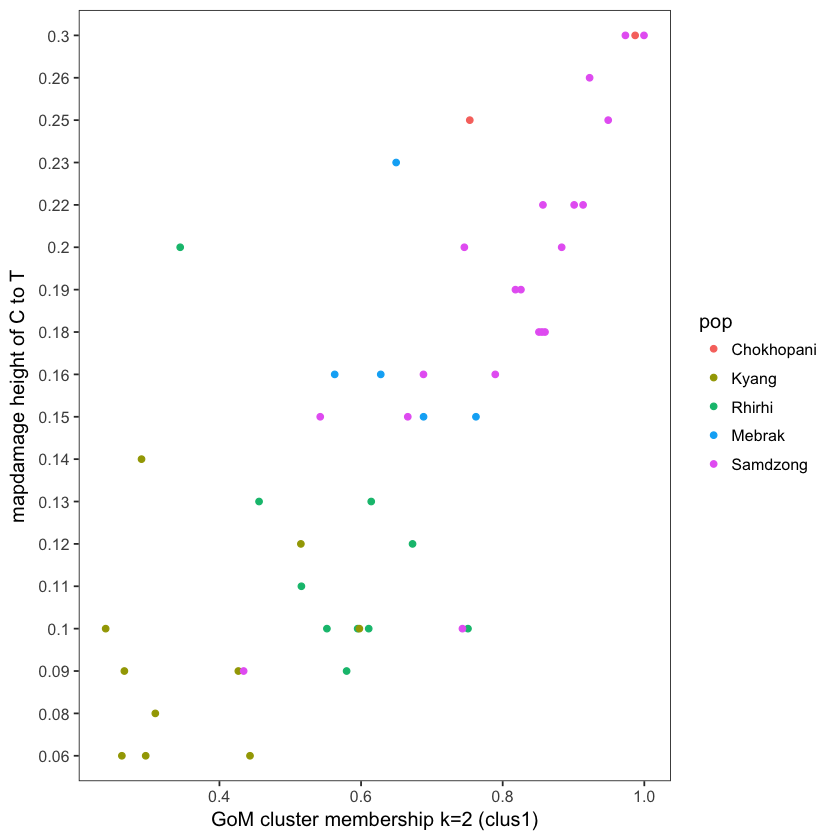

In [15]:
## Plot of the membership proportions to the mapdamage height of C to T

tmp <- metadata$MapDamage[indices]  

dat <- data.frame("omega" = omega[,1], "damage"= tmp, "pop"= pop_names_1)
ggplot2::qplot(omega, damage, col=pop, data=dat, xlab="GoM cluster membership k=2 (clus1)",
               ylab="mapdamage height of C to T")

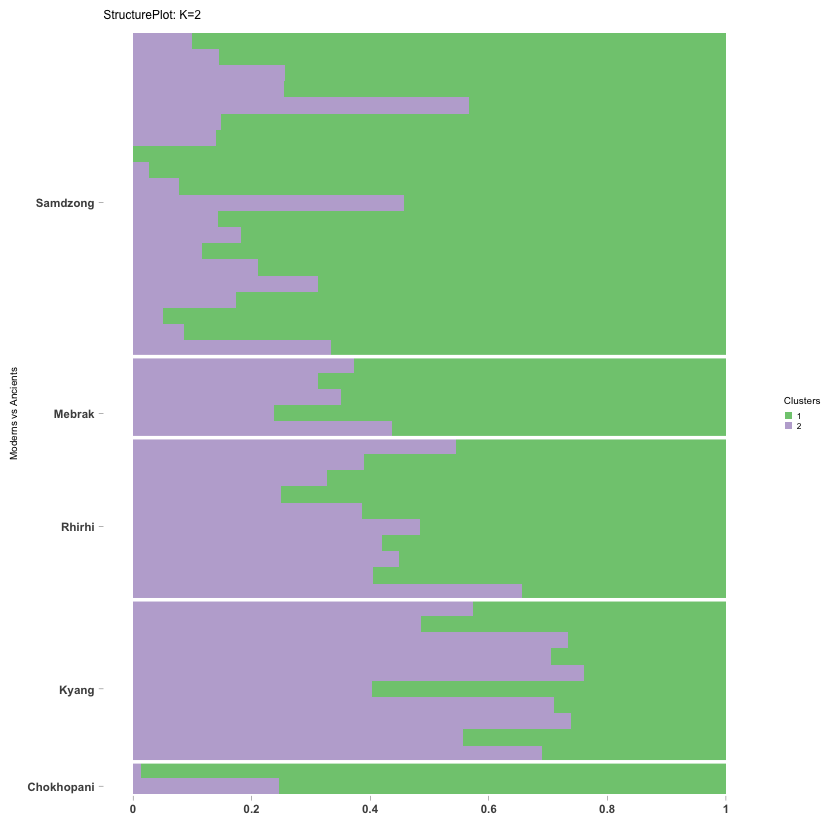

In [16]:
## plot the membership proportions 

omega <- topic_clus$omega
labs <- rep("goss-ancient", dim(omega)[1])

annotation <- data.frame(
  sample_id = paste0("X", c(1:NROW(omega))),
  tissue_label = factor(pop_names_1)
)

CountClust::StructureGGplot(omega = omega,
                            annotation = annotation,
                            palette = RColorBrewer::brewer.pal(8, "Accent"),
                            yaxis_label = "Moderns vs Ancients",
                            order_sample = FALSE,
                            figure_title = paste0("StructurePlot: K=", dim(omega)[2],""),
                            axis_tick = list(axis_ticks_length = .1,
                                             axis_ticks_lwd_y = .1,
                                             axis_ticks_lwd_x = .1,
                                             axis_label_size = 7,
                                             axis_label_face = "bold"))

## Summary

In this script, we filtered out the ancient samples from gossling data and performed a K=2 GoM clustering and visualized the results to see how the different ancient samples differ, The Samdzong samples seemed to differ from the others in having steeper c to T patterns. 

We then compared the GoM membership proportions in the first cluster with respect to the endogenous DNA content, the Mapdamage height of C to T and the sex determination. We observed that the mapdamage height is proportional to the membership proportions, the endogenous DNA content was somewhat negatively correlated, but that was mainly because Samdzong samples have very low amounts of endogenous DNA.

